# **Module 1(Full Pose Dectection)**

In [ ]:
#impor libaries and git repos 

import os
import shutil
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/lxy5513/hrnet.git'
project_name = splitext(basename(git_repo_url))[0]
!pip install -q youtube-dl EasyDict==1.7 Cython pyyaml json_tricks scikit-image yacs>=0.1.5 ipdb
!cd {project_name}/lib && make
if not exists(project_name):
  # clone and install dependencies
  !git clone -q {git_repo_url}
  #!cd {project_name} && pip install -q -r requirements.txt
  !pip install -q youtube-dl EasyDict==1.7 Cython pyyaml json_tricks scikit-image yacs>=0.1.5 ipdb
  !cd {project_name}/lib && make
  
import sys
sys.path.append(project_name)
sys.path.append(join(project_name, 'tools'))
sys.path.append(join(project_name, 'lib'))
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.18 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.22.0 which is incompatible.
/bin/bash: line 0: cd: hrnet/lib: No such file or directory
cd nms; python setup_linux.py build_ext --inplace; rm -rf build; cd ../../
running build_ext
cythoning cpu_nms.pyx to cpu_nms.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/hrnet/lib/nms/cpu_nms.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
skipping 'gpu_nms.cpp' Cython extension (up-to-date)
building 'cpu_nms' extension
creating build
creating build/temp.linux-x86_64-3.7
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3

<h3>Downloading the Pre-Trained models coco and Yolov3</h3>

In [ ]:
#copy required weights, pre-trained models
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}
  

pretrained_model_parent_directory = 'models/pytorch/pose_coco'
pretrained_model_path = join(project_name, pretrained_model_parent_directory, 'pose_hrnet_w48_256x192.pth')
if not exists(pretrained_model_path):
  # download the pretrained model
  !rm -rf {project_name}/models
  !mkdir -p {project_name}/{pretrained_model_parent_directory}
  download_from_google_drive('15T2XqPjW7Ex0uyC1miGVYUv7ULOxIyJI', pretrained_model_path)
  
yolo_pretrained_model_path = join(project_name, 'lib/detector/yolo/yolov3.weights')
if not exists(yolo_pretrained_model_path):
  # download the YOLO weights
  !cd {project_name}/lib/detector/yolo/ && wget -q https://pjreddie.com/media/files/yolov3.weights

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   2853      0 --:--:-- --:--:-- --:--:--  2853
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  243M    0  243M    0     0   123M      0 --:--:--  0:00:01 --:--:--  201M


In [ ]:
import cv2
import numpy as np
from utilitys import plot_keypoint, PreProcess
from lib.core.inference import get_final_preds
import torch
import config
import models
from config import cfg, update_config
from types import SimpleNamespace
from google.colab.patches import cv2_imshow

from lib.detector.yolo.human_detector import human_bbox_get as yolo_det
from lib.detector.yolo.human_detector import load_model as yolo_model


update_config(cfg,SimpleNamespace(cfg = join(project_name, 'experiments/coco/hrnet/w48_256x192_adam_lr1e-3.yaml'),
                              opts = '',
                              modelDir='', logDir='', dataDir='', prevModelDir=''))

#function to load the model
def model_load(config):
  model = models.pose_hrnet.get_pose_net(config, is_train=False)
  model_file_name  = join(project_name, 'models/pytorch/pose_coco/pose_hrnet_w48_256x192.pth')
  state_dict = torch.load(model_file_name)
  from collections import OrderedDict
  new_state_dict = OrderedDict()
  for k, v in state_dict.items():
      name = k # remove module.
      #  print(name,'\t')
      new_state_dict[name] = v
  model.load_state_dict(new_state_dict)
  model.eval()
  return model
  
#calling the function with updated configuration
pose_model = model_load(cfg).cuda()#HrNet model


human_model = yolo_model()#YOLO V3 model

Loading network.....
Network successfully loaded


<h3>Detect full pose image</h3>

In [ ]:
#function to detect full pose image

def detect_pose(pa,c):

  image = pa
  frame = cv2.imread(image, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
  bboxs, scores = yolo_det(frame, human_model)
  src_dir = pa 
  if len(bboxs)>0:
    inputs, origin_img, center, scale = PreProcess(frame, bboxs, scores, cfg)

    with torch.no_grad():
      # compute output heatmap
      inputs = inputs[:,[2,1,0]]
      output = pose_model(inputs.cuda())
      
      # compute coordinate
      preds, maxvals = get_final_preds(
          cfg, output.clone().cpu().numpy(), np.asarray(center), np.asarray(scale))
      thresh = 0.7
      if maxvals[0][0]>thresh and maxvals[0][1]>thresh and maxvals[0][2]>thresh and maxvals[0][3]>thresh and maxvals[0][4]>thresh and maxvals[0][13]>thresh and maxvals[0][14]>thresh and maxvals[0][15]>thresh and maxvals[0][16]>thresh:
        #dst_dir = '/content/full_shot' + '/' + f'image_{c}' + '.jpg' -- want to move all full shot to single folder
        #shutil.copy(src_dir,dst_dir)
        return 1
      else:
        return 0
        
  else:
    return 0

Image that are detected as full pose images will be passed to second object localization module training.

# **Module 2 (Fashion Objects localiztion)**
this module use object detection techniques to localizalize fashion objects in the images 

In [ ]:
!pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3MB 39kB/s 
     |████████████████████████████████| 512kB 49.3MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 3.8MB 45.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=c16dee903df5849537943e5c1c5ff67a596d642fbf74ba82b6453ad913c46103
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

In [ ]:
# We should be able to directly predict using saved model so I am again importing all modules

!pip install keras==2.1.6

     |████████████████████████████████| 348kB 18.8MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path


import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

In [ ]:
# For demonstration purpose, the classification ignores attributes (only categories),
# and the image size is set to 512, which is the same as the size of submission masks
number_categorys = 46
image_size = 512

In [ ]:
!git clone https://www.github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 39.87 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [ ]:
!gdown --id 1WjvW3PI27bkzzBtIu6cx6goHjPBlQntA

Downloading...
From: https://drive.google.com/uc?id=1WjvW3PI27bkzzBtIu6cx6goHjPBlQntA
To: /content/label_descriptions.json
100% 16.1k/16.1k [00:00<00:00, 7.76MB/s]


In [ ]:
#Download label and pre-trained Mask-RCNN weights
!gdown --id 1d8weOjj6XB-Svt1_9OMVNskoodoC-Uqi

Downloading...
From: https://drive.google.com/uc?id=1d8weOjj6XB-Svt1_9OMVNskoodoC-Uqi
To: /content/mask_rcnn_fashion_0008.h5
180MB [00:03, 50.3MB/s]


In [ ]:
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

In [ ]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [ ]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [ ]:
class FashionConfiguration(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 # a memory error occurs when IMAGES_PER_GPU is too high
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_NMS_THRESHOLD = 0.0
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
    
config = FashionConfiguration()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [ ]:

#Load Trained Mask RCNN model
class InferenceConfig(FashionConfiguration):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,model_dir=ROOT_DIR)

model_path ='/content/mask_rcnn_fashion_0008.h5'
assert model_path != '', "Provide path to trained weights"


print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
"""
Below are all utility functions that are used for task like cropping or to get image from url, plot image etc...
"""

#combine categories for simplification
feet = ['shoe']
upperbody = ['cardigan',
 'collar',
 'epaulette',
 'hood',
 'jacket',
 'lapel',
 'neckline',
 'shirt, blouse',
 'sleeve',
 'sweater',
 'top, t-shirt, sweatshirt',
 'vest']

lowerbody = ['pants', 'pocket', 'shorts', 'skirt']
wholebody = ['cape', 'coat', 'dress', 'jumpsuit']

def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img


def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

with open('/content/label_descriptions.json') as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]  


def get_bounding_box(path):

  image_path = path
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  result = model.detect([resize_image(image_path)])
  r = result[0]

  if r['masks'].size > 0:
      masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
      for m in range(r['masks'].shape[-1]):
          masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                      (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
      
      y_scale = img.shape[0]/IMAGE_SIZE
      x_scale = img.shape[1]/IMAGE_SIZE
      rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
      
      masks, rois = refine_masks(masks, rois)
      return img, masks, rois, r
  else:
      masks, rois = r['masks'], r['rois']
      return img,masks, rois, r
  
  
      

#here we will get boxes for our combined category

def get_image_parts(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    masked_image = image.astype(np.uint32).copy()

    feet_temp = []
    upperbody_temp = []
    lowerbody_temp = []
    wholebody_temp = []

    for i in range(N):
        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
            # print(f'class id: {class_id}, score: {score}, lable: {label},caption:{caption}')
            # print(y1, x1, y2, x2)
            if score>0.70:
              if label in feet:
                feet_temp.append((y1, x1, y2, x2))
              if label in upperbody:
                upperbody_temp.append((y1, x1, y2, x2))
              if label in lowerbody:
                lowerbody_temp.append((y1, x1, y2, x2))
              if label in wholebody:
                wholebody_temp.append((y1, x1, y2, x2))
        else:
            caption = captions[i]
    
    return  feet_temp ,upperbody_temp,lowerbody_temp , wholebody_temp



#get only objects from the boxes
def crop(y1,x1,y2,x2,img):
  outimage = img[int(y1):int(y2), int(x1):int(x2)]
  return outimage

def get_min_max(li,no,typee):
  mini = []
  for i in li:
    mini.append(i[no])
  if typee=='min': 
    return min(mini)
  if typee=='max':
    return max(mini)

def get_crop_image(img,li,name):
  #n = len(li)
  images = []
  if name=='feet':
    for i in li:
      outimage = crop(i[0],i[1],i[2],i[3],img)
      images.append(outimage)
  if name=='full':
    for i in li:
      outimage = crop(i[0],i[1],i[2],i[3],img)
      images.append(outimage)
  if name=='upp':
    y1 = get_min_max(li,0,'min')
    x1 = get_min_max(li,1,'min')
    y2 = get_min_max(li,2,'max')
    x2 = get_min_max(li,3,'max')
    outimage = crop(y1,x1,y2,x2,img)
    images.append(outimage)

  if name=='bott':
    y1 = get_min_max(li,0,'min')
    x1 = get_min_max(li,1,'min')
    y2 = get_min_max(li,2,'max')
    x2 = get_min_max(li,3,'max')
    outimage = crop(y1,x1,y2,x2,img)
    images.append(outimage)
  return images


def object_detctions(path):
  img , masks, rois, r = get_bounding_box(path)
  feet_temp ,upperbody_temp,lowerbody_temp , wholebody_temp = get_image_parts(img, rois, masks, r['class_ids'], 
                              ['bg']+label_names, r['scores'],
                              title=path, figsize=(12, 12),show_mask=False)
  feet_images = []
  whole_images = []
  upperbody_images = []
  lowerbody_images = []
  if len(feet_temp)>0:
    feet_images = get_crop_image(img,feet_temp,'feet')
  if len(wholebody_temp)>0:
    whole_images = get_crop_image(img,wholebody_temp,'full')
  if len(upperbody_temp)>0:
    upperbody_images = get_crop_image(img,upperbody_temp,'upp')
  if len(lowerbody_temp)>0:
    lowerbody_images = get_crop_image(img,lowerbody_temp,'bott')
  
  return img , masks, rois, r , feet_images, whole_images, upperbody_images, lowerbody_images

This crop images will be passed to module 3 to convert them to embeddings

# **Module 3 (Generate embeddings of images)**

In [ ]:
import tensorflow as tf
import datetime as dt
import cv2
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import json
import os

In [ ]:
#Load pre-trained DenseNet121 model
model_embedding = tf.keras.applications.DenseNet121(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=(520,520,3),
    pooling=None,
)
def load_img(img):

  img = cv2.imread(path,cv2.IMREAD_UNCHANGED) 
  img = cv2.resize(img,(520,520),interpolation=cv2.INTER_AREA)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = tf.image.convert_image_dtype(img,tf.float32)[tf.newaxis, ...] 
  return img 

def get_embeddings(path):
  img = load_img(path)
  op = model_embedding.predict(img,steps=1)
  op = tf.squeeze(op, axis=None, name=None)
  op = tf.reduce_mean(op, axis=(0,1), keepdims=False, name=None)
  op = op.eval(session=tf.Session()) 
  op = op.tolist()
  return op

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
29089792/29084464 [==============================] - 0s 0us/step


# **Module 4 (Search embeddings)**

In [ ]:
os.chdir('/content')

In [ ]:
!pip install faiss-gpu
!pip install -q kaggle

     |████████████████████████████████| 89.4MB 160kB/s 


In [ ]:
#final file
!gdown --id 1wDMBZIABSRsdiLYQ5Y9uBzh41a5nX2qt

Downloading...
From: https://drive.google.com/uc?id=1wDMBZIABSRsdiLYQ5Y9uBzh41a5nX2qt
To: /content/Final.csv
1.67GB [00:20, 79.5MB/s]


In [ ]:
#kaggle json file
!gdown --id 1iVn4WhmZoq7lWgB1cPE6F8LzkQbf1dQ8

Downloading...
From: https://drive.google.com/uc?id=1iVn4WhmZoq7lWgB1cPE6F8LzkQbf1dQ8
To: /content/kaggle.json
100% 68.0/68.0 [00:00<00:00, 137kB/s]


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import faiss                   
from tqdm.notebook import tqdm
import pandas as pd
import json
import os

In [ ]:
df = pd.read_csv('/content/Final.csv').drop('Unnamed: 0',axis=1)

In [ ]:
#downloaded the dataset from kaggle
!kaggle datasets download -d shreyas90999/mycasestudy02ee

100% 11.1G/11.1G [04:27<00:00, 25.3MB/s]
100% 11.1G/11.1G [04:27<00:00, 44.5MB/s]


In [ ]:
!mkdir data
!unzip -q '/content/mycasestudy02ee.zip' -d '/content/data'

In [ ]:
!rm -rf '/content/mycasestudy02ee.zip'

In [ ]:
#download embedding file
!gdown --id 1--MkT6uKuDr8Rxc5HG0PkDtpf3MRBKP7
!gdown --id 1-9F0EnkMRu8gGYUiU7GpKtG9n3GTi3qY
!gdown --id 1IlDwliCAXPIs3IQGFxyLhcv9RZwGQaL4

Downloading...
From: https://drive.google.com/uc?id=1--MkT6uKuDr8Rxc5HG0PkDtpf3MRBKP7
To: /content/foot_vec.index
100% 1.66M/1.66M [00:00<00:00, 26.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-9F0EnkMRu8gGYUiU7GpKtG9n3GTi3qY
To: /content/lower_vec.index
100% 1.42M/1.42M [00:00<00:00, 22.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IlDwliCAXPIs3IQGFxyLhcv9RZwGQaL4
To: /content/upper_vec.index
100% 1.34M/1.34M [00:00<00:00, 20.9MB/s]


In [ ]:
def search_similar_image(query_vec,index_lable):
  k = 10
  
  if index_lable=='upper_ware':
    upper_index = faiss.read_index("/content/upper_vec.index")  # load the index
    search_df = df.loc[df['super_cat']==index_lable]
    search_df.reset_index(inplace = True,drop = True)
    query_emb = np.array(query_vec) # converting the list to array for seraching the product
    query_emb= query_emb.astype('float32')
    row_vector = query_emb[np.newaxis,:]
    D, I = upper_index.search(row_vector, k)
    
    #filtering the product based on the index
    rec_pro = search_df[search_df.index.isin(I[0])]
    return rec_pro
  if index_lable=='lower_ware':
    lower_index = faiss.read_index("/content/lower_vec.index")  # load the index
    search_df = df.loc[df['super_cat']==index_lable]
    search_df.reset_index(inplace = True,drop = True)
    query_emb = np.array(query_vec) # converting the list to array for seraching the product
    query_emb= query_emb.astype('float32')
    row_vector = query_emb[np.newaxis,:]
    D, I = lower_index.search(row_vector, k)
    
    #filtering the product based on the index
    rec_pro = search_df[search_df.index.isin(I[0])]
    return rec_pro
  if index_lable=='foot_ware':
    foot_index = faiss.read_index("/content/foot_vec.index")  # load the index
    search_df = df.loc[df['super_cat']==index_lable]
    search_df.reset_index(inplace = True,drop = True)
    query_emb = np.array(query_vec) # converting the list to array for seraching the product
    query_emb= query_emb.astype('float32')
    row_vector = query_emb[np.newaxis,:]
    D, I = foot_index.search(row_vector, k)
    
    #filtering the product based on the index
    rec_pro = search_df[search_df.index.isin(I[0])]
    return rec_pro

#**Final Predict Function**

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=b81f7af8d5e6bc7866a836927a7e3601b33d99534f811a2cef104e975db5cb28
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
import cv2, wget
#utility finctions

def print_recommendations(response):
  c=1
  flag = []
  def url_to_image(link):
    image_url = link
    filename = wget.download(image_url)
    img = cv2.imread(filename,cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img


  def get_image_links(n,df):
    id = int(n)
    root = '/content/data/'
    path = root + df['cat'][id] + '/' + df['info'][id]
    f = open(path)
    data = json.load(f)
    li = data['links']
    f.close()
    return li


  def plot_images(li):
    fig, ax = plt.subplots(1,len(li), figsize=(20,20))
    for i in range(len(li)): 
      outimage = li[i]
      auto_show = True
      height, width = outimage.shape[:2]
      ax[i].set_ylim(height + 10, -10)
      ax[i].set_xlim(-10, width + 10)
      ax[i].axis('off')
      img1 = outimage.astype(np.uint32).copy()
      ax[i].imshow(img1.astype(np.uint8))
    plt.show()

  for i,row in response.iterrows():
    url = row['url']
    id = row['id']
    if url not in flag:
      flag.append(url)
      links = get_image_links(int(id),df)
      images = []
      for j in links:
        img = url_to_image(j)
        images.append(img)
      print(f"recomendation {c}")
      print("You can buy product from below link")
      print(url)
      print("="*200)
      plot_images(images)
      print("="*200)
      c+=1
      if c==6:
        break

In [ ]:
os.chdir('/content/Mask_RCNN')

In [ ]:
#Final function used for prediction
def buy_me_that_look(path):
  
  if detect_pose(path,0)==0:                                            #Module-1
    print("Not a Full Pose Image, Insert a Full Pose Image")
  else:
    print("Input Image is Full Pose...........")
    print("Searching for fashion objects...........")
    t = dt.datetime.now()
    img , masks, rois, r , feet_images,whole_images,upperbody_images,lowerbody_images = object_detctions(path)#Module-2
    print("Time taken to locate all objects ", dt.datetime.now()-t )
    print("Below is the image with all detected fashion objects")
    print('+'*200)
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                              ['bg']+label_names, r['scores'],
                              title=path, figsize=(8,8),show_mask=False)
    print('+'*200)

    if len(upperbody_images)>0:                                                    
      c=1
      
      for i in upperbody_images:
        index_lable = 'upper_ware'
        print(f"*********Query Image {c} to find upper body clothes****************")
        outimage = i
        _, ax = plt.subplots(1, figsize=(4,4))
        auto_show = True

        height, width = outimage.shape[:2]
        ax.set_ylim(height + 10, -10)
        ax.set_xlim(-10, width + 10)
        ax.axis('off')
        img1 = outimage.astype(np.uint32).copy()
        ax.imshow(img1.astype(np.uint8))
        plt.show()    
        t = dt.datetime.now()
        query_vec = get_embeddings(i)                                           #Module-3
        print("Time taken to do embedding of image ", dt.datetime.now()-t )
        print("Searching for images....... ")
        t = dt.datetime.now()
        response = search_similar_image(query_vec,index_lable)                  #Module-4
        
        print("Time taken to search similar images ", dt.datetime.now()-t )
        print('='*200)
        print_recommendations(response)

    if len(lowerbody_images)>0:
      c=1
      index_lable = 'lower_ware'
      for i in lowerbody_images:
        print(f"******************Query Image {c} to find lower body clothes************")
        outimage = i
        _, ax = plt.subplots(1, figsize=(4,4))
        auto_show = True

        height, width = outimage.shape[:2]
        ax.set_ylim(height + 10, -10)
        ax.set_xlim(-10, width + 10)
        ax.axis('off')
        img1 = outimage.astype(np.uint32).copy()
        ax.imshow(img1.astype(np.uint8))
        plt.show()    
        t = dt.datetime.now()
        query_vec = get_embeddings(i)                                         #Module-3
        print("Time taken to do embedding of image ", dt.datetime.now()-t )
        print("Searching for images....... ")
        t = dt.datetime.now()
        response = search_similar_image(query_vec,index_lable)                #Module-4
        
        print("Time taken to search similar images ", dt.datetime.now()-t )
        print('='*200)
        print_recommendations(response)


    if len(feet_images)>0:
      c=1
      index_lable = 'foot_ware'
      for i in feet_images:
        print(f"****************Query Image {c} to find foot wear********************")
        outimage = i
        _, ax = plt.subplots(1, figsize=(4,4))
        auto_show = True

        height, width = outimage.shape[:2]
        ax.set_ylim(height + 10, -10)
        ax.set_xlim(-10, width + 10)
        ax.axis('off')
        img1 = outimage.astype(np.uint32).copy()
        ax.imshow(img1.astype(np.uint8))
        plt.show()    
        t = dt.datetime.now()
        query_vec = get_embeddings(i)                                       #Module-3
        print("Time taken to do embedding of image ", dt.datetime.now()-t )
        print("Searching for images....... ")
        t = dt.datetime.now()
        response = search_similar_image(query_vec,index_lable)              ##Module-4
        
        
        print("Time taken to search similar images ", dt.datetime.now()-t )
        print('='*200)
        print_recommendations(response)

Input Image is Full Pose...........
Searching for fashion objects...........
Time taken to locate all objects  0:00:00.769914
Below is the image with all detected fashion objects
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


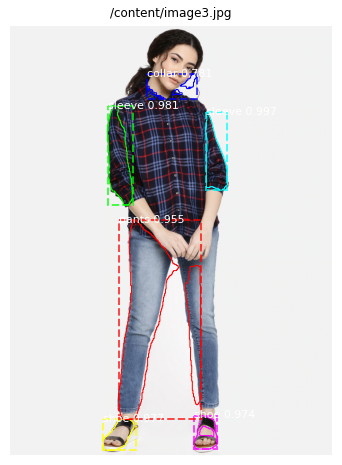

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
*********Query Image 1 to find upper body clothes****************


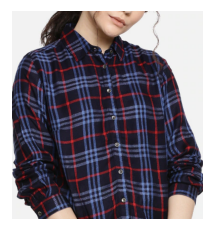

Time taken to do embedding of image  0:00:02.821297
Searching for images....... 
[[12425 13513 10465 13567  8944 16548 15290  9409 16035 13431]]
Time taken to search similar images  0:00:00.011701
recomendation 1
You can buy product from below link
https://www.myntra.com/tops/american-eagle-outfitters/american-eagle-outfitters-women-mustard-yellow--white-striped-shirt-style-top/11853350/buy


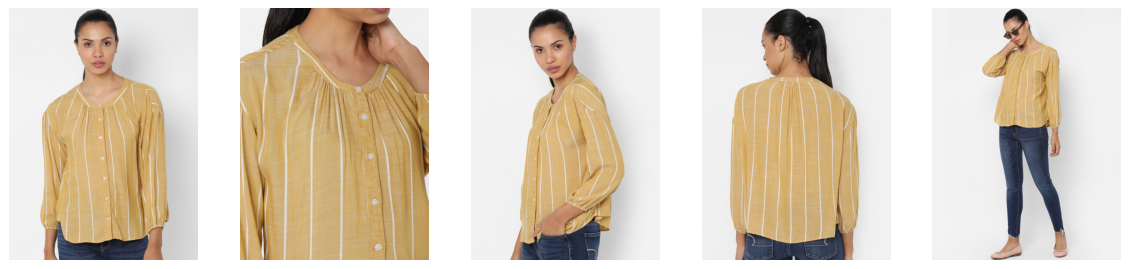

recomendation 2
You can buy product from below link
https://www.myntra.com/tops/kazo/kazo-women-mustard-self-design-cinched-waist-top/11558072/buy


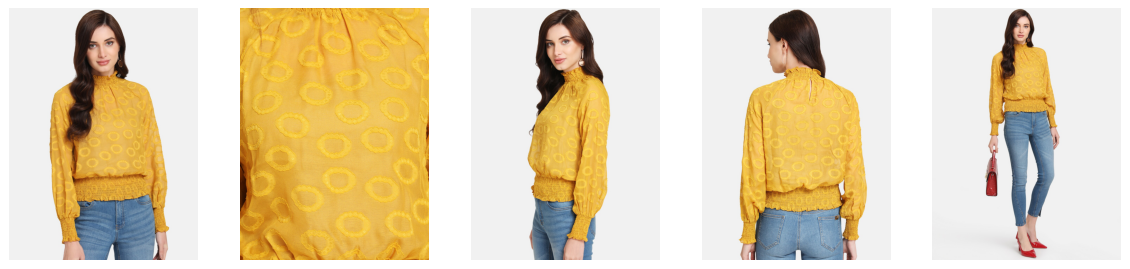

recomendation 3
You can buy product from below link
https://www.myntra.com/shirts/columbia/columbia-women-blue-checked-outdoor-shirt/1255659/buy


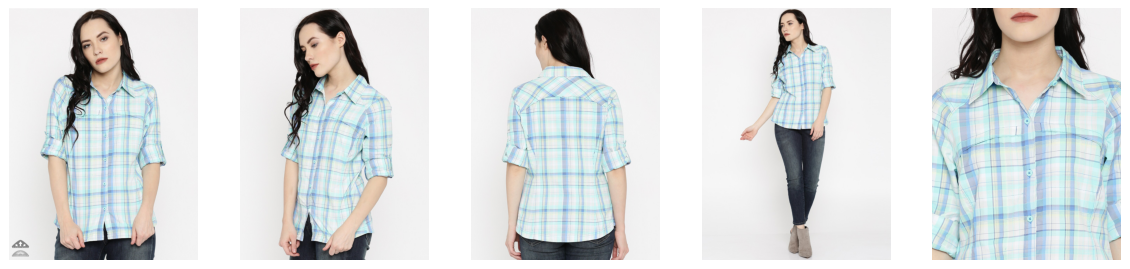

recomendation 4
You can buy product from below link
https://www.myntra.com/shirts/junarose/junarose-plus-size-women-navy-blue--red-checked-casual-shirt/2135789/buy


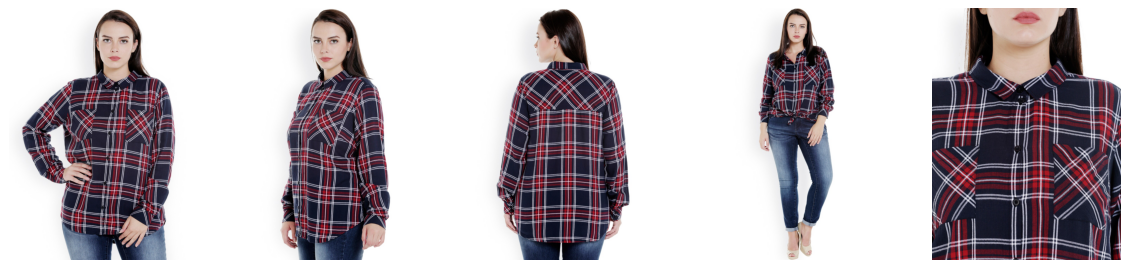

recomendation 5
You can buy product from below link
https://www.myntra.com/shirts/junarose/junarose-plus-size-women-blue-regular-fit-solid-casual-shirt/9450741/buy


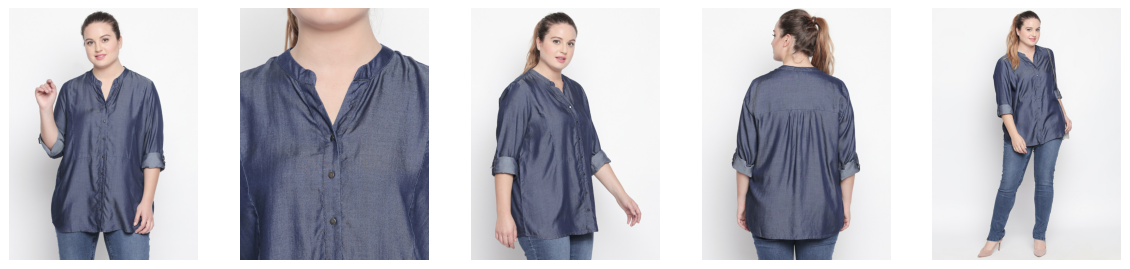

******************Query Image 1 to find lower body clothes************


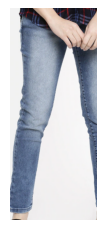

Time taken to do embedding of image  0:00:02.869705
Searching for images....... 
[[13325 13950 14271 13954 16710 16345 13911 14843 10339 11364]]
Time taken to search similar images  0:00:00.025882
recomendation 1
You can buy product from below link
https://www.myntra.com/trousers/hm/hm-women-olive-green-linen-joggers/11926830/buy


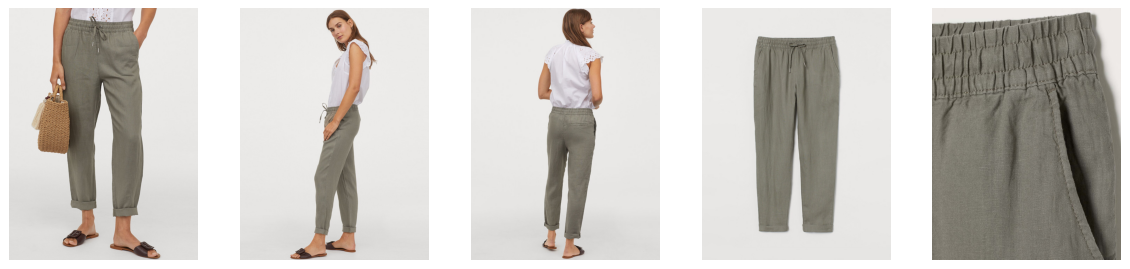

recomendation 2
You can buy product from below link
https://www.myntra.com/jeans/desigual/desigual-women-blue-boyfriend-fit-low-rise-mildly-distressed-jeans/10985676/buy


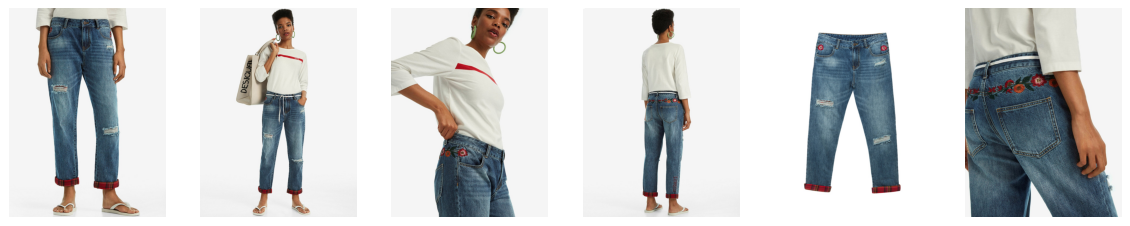

recomendation 3
You can buy product from below link
https://www.myntra.com/jeans/ovs/ovs-women-navy-blue-regular-fit-mid-rise-clean-look-stretchable-jeans/7208785/buy


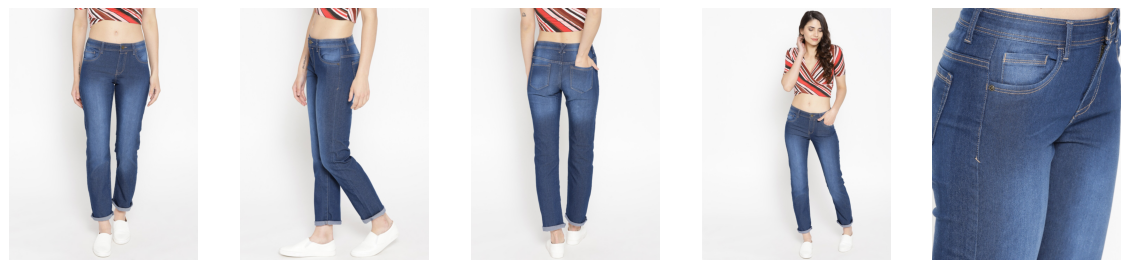

recomendation 4
You can buy product from below link
https://www.myntra.com/jeans/ovs/ovs-women-blue-slim-fit-mid-rise-clean-look-cropped-stretchable-jeans/7560666/buy


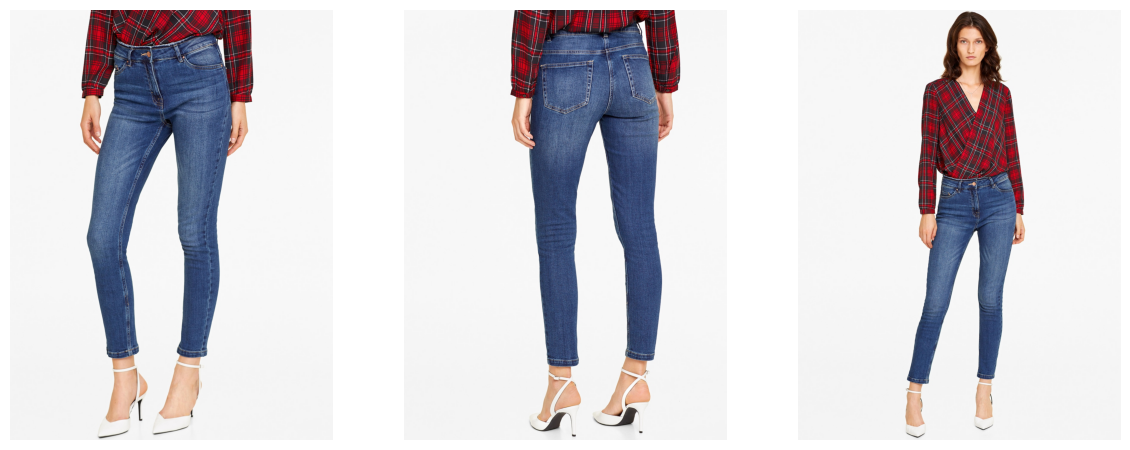

recomendation 5
You can buy product from below link
https://www.myntra.com/jeans/united-colors-of-benetton/united-colors-of-benetton-women-blue-skinny-fit-high-rise-clean-look-stretchable-jeans/7582834/buy


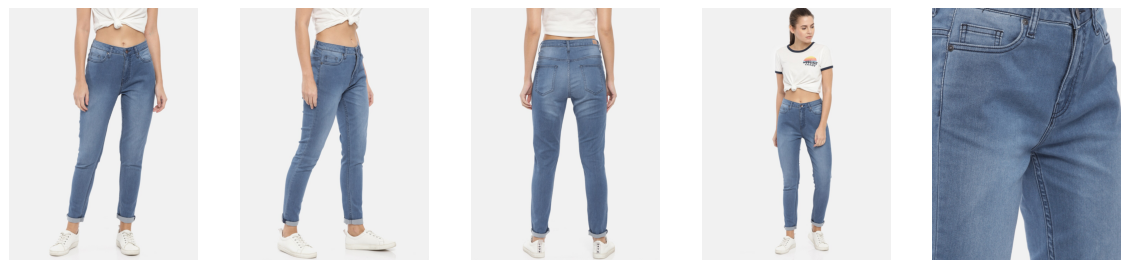

****************Query Image 1 to find foot wear********************


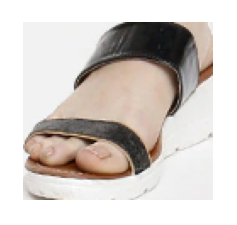

Time taken to do embedding of image  0:00:03.022380
Searching for images....... 
[[28051 29676  8189 28123 31349 21430 33539 19610 12314 20202]]
Time taken to search similar images  0:00:00.032196
recomendation 1
You can buy product from below link
https://www.myntra.com/heels/charles--keith/charles--keith-women-yellow--black-animal-skin-textured-pumps/12087382/buy


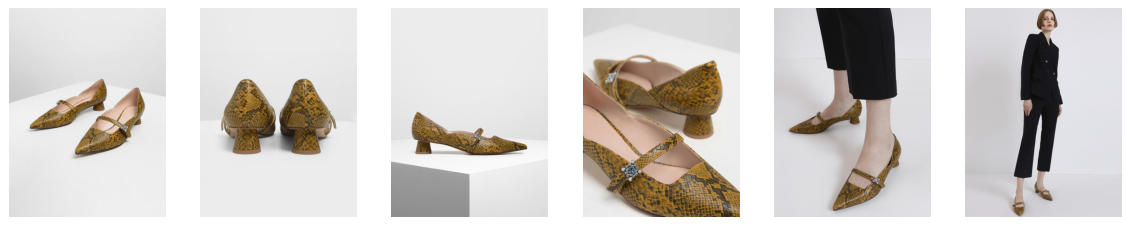

recomendation 2
You can buy product from below link
https://www.myntra.com/heels/truffle-collection/blue-boots/7936783/buy


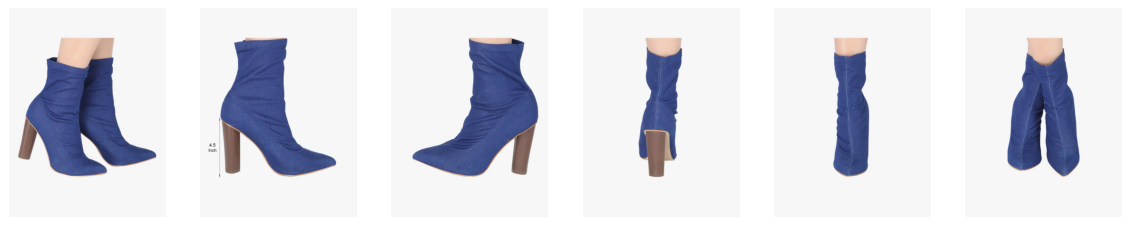

recomendation 3
You can buy product from below link
https://www.myntra.com/heels/charles--keith/charles--keith-women-brown-solid-pumps/12087406/buy


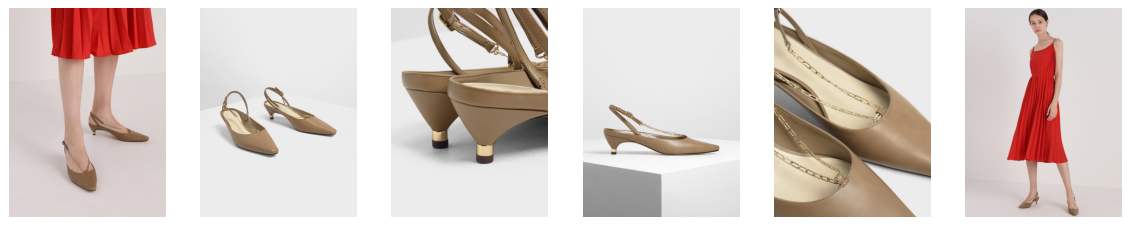

recomendation 4
You can buy product from below link
https://www.myntra.com/flats/charles--keith/charles--keith-women-black-solid-open-toe-flats/11920388/buy


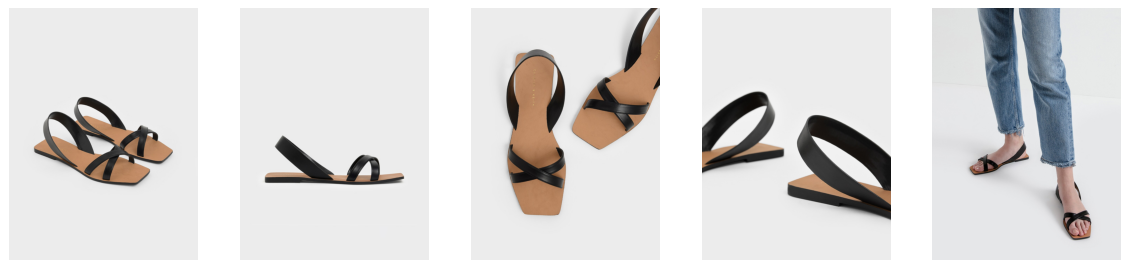

recomendation 5
You can buy product from below link
https://www.myntra.com/flats/charles--keith/charles--keith-women-black-solid-open-toe-flats/12087476/buy


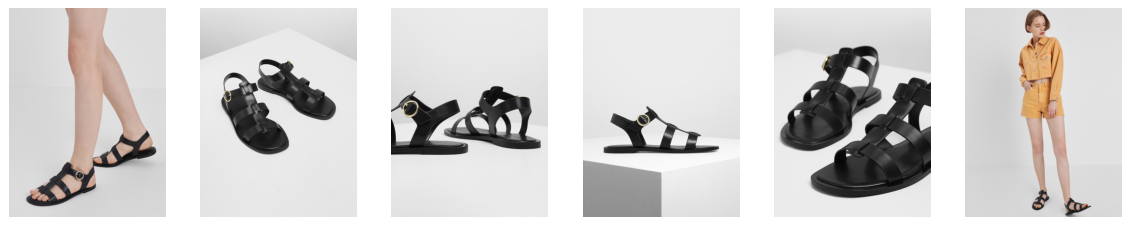

****************Query Image 1 to find foot wear********************


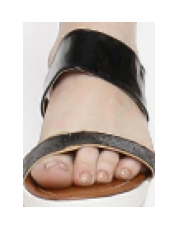

Time taken to do embedding of image  0:00:03.007047
Searching for images....... 
[[28051 29676  8189 28123 31349 21430 33539 19610 12314 20202]]
Time taken to search similar images  0:00:00.016617
recomendation 1
You can buy product from below link
https://www.myntra.com/heels/charles--keith/charles--keith-women-yellow--black-animal-skin-textured-pumps/12087382/buy


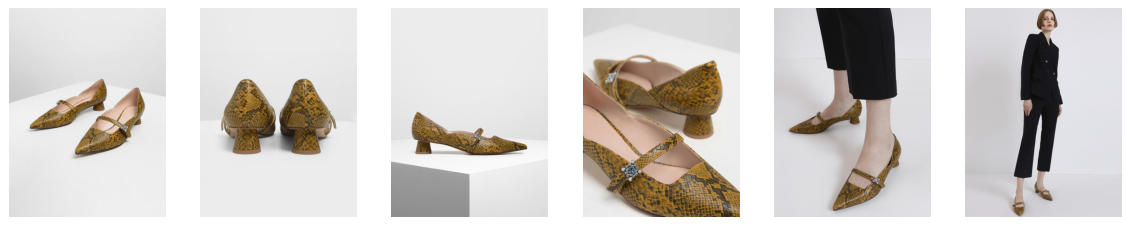

recomendation 2
You can buy product from below link
https://www.myntra.com/heels/truffle-collection/blue-boots/7936783/buy


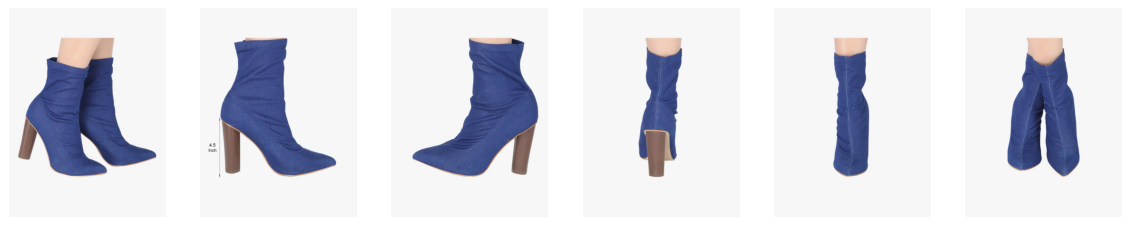

recomendation 3
You can buy product from below link
https://www.myntra.com/heels/charles--keith/charles--keith-women-brown-solid-pumps/12087406/buy


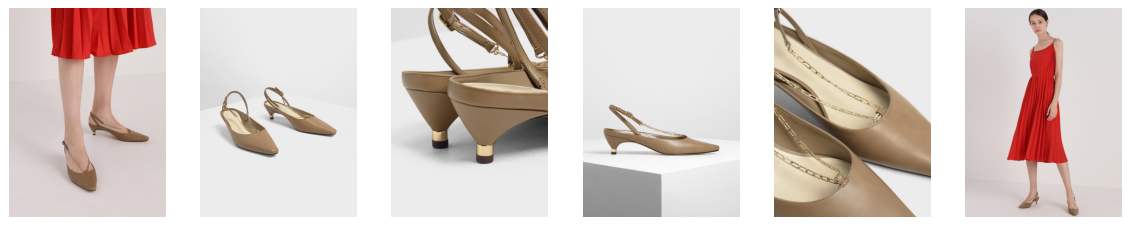

recomendation 4
You can buy product from below link
https://www.myntra.com/flats/charles--keith/charles--keith-women-black-solid-open-toe-flats/11920388/buy


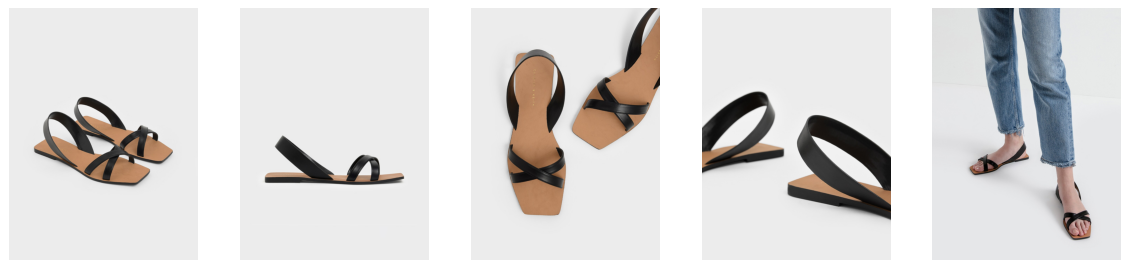

recomendation 5
You can buy product from below link
https://www.myntra.com/flats/charles--keith/charles--keith-women-black-solid-open-toe-flats/12087476/buy


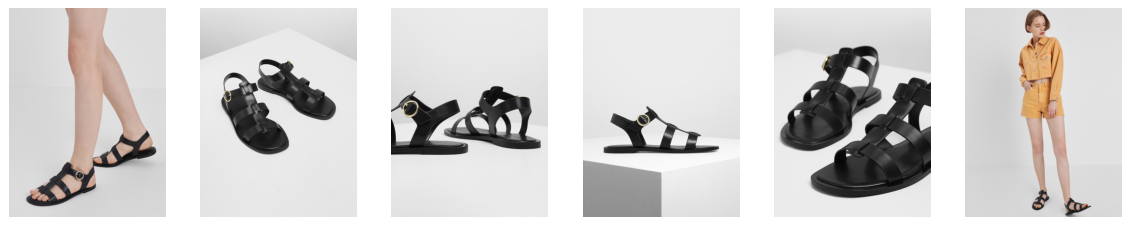

In [ ]:
path = '/content/image3.jpg'
buy_me_that_look(path)